## Spectral differentiation

The following code defines the Chebychev spectral differentiation matrix. The code is a Python adaption of the corresponding code in the book `Spectral Methods in Matlab` by L. N. Trefethen. The Python version can be found at http://blue.math.buffalo.edu/438/trefethen_spectral/all_py_files/cheb.py

In [1]:
import numpy as np

def cheb(N):
    if N==0: 
        D = np.array([[0.]]); x = np.array([1.])
    else:
        n = np.arange(0,N + 1)
        x = np.cos(np.pi* n / N).reshape(N + 1, 1) 
        c = (np.hstack(( [2.], np.ones(N - 1), [2.]))*(-1)**n).reshape(N + 1,1)
        X = np.tile(x,(1,N + 1))
        dX = X - X.T
        D = np.dot(c,1./c.T)/(dX + np.eye(N + 1))
        D -= np.diag( np.sum( D.T, axis=0))
    return D, x.reshape(N + 1)

Let us play with the code. We define a function, take its derivative and compare with the analytic derivative for growing N. We then plot the resulting error.

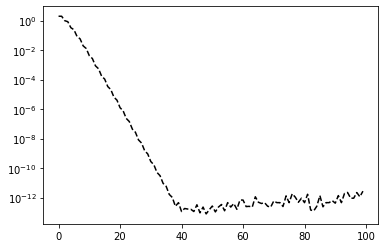

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

errors = []

for N in range(100):
    D, x = cheb(N)
    f = 1 / (2 - x**2)
    df = 2 * x / (2 - x**2)**2
    df_cheb = D @ f
    error = np.linalg.norm(df - df_cheb, np.inf)
    errors.append(error)
plt.semilogy(errors, 'k--')

This works well. Let us use this to solve a differential equation. The ODE is given as $\frac{d^2u}{dx^2} - x^2 u = 0$ with boundary conditions $u(-1) = u(1) = 1$. The discretisation of the ODE is obtained as follows:

In [3]:
N = 50
D, x = cheb(N)
lhs = D @ D - np.diag(x**2)
lhs[0, :] = np.zeros(N + 1)
lhs[-1, :] = np.zeros(N + 1)
lhs[0, 0] = lhs[-1, -1] = 1
rhs = np.zeros(N + 1)
rhs[0] = rhs[-1] = 1

Now let's solve it and plot the solution.

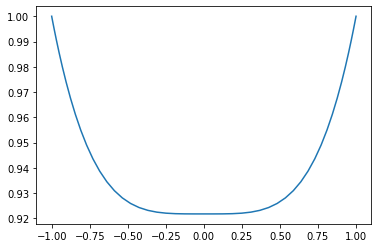

In [4]:
sol = np.linalg.solve(lhs, rhs)
plt.plot(x, sol)

With a few lines of code we have solved a nasty boundary value problem.

Now let us solve the Laplace equation $-\Delta u = 1$ with zero boundary conditions on the unit square.

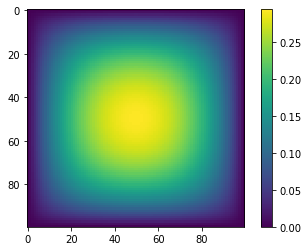

In [5]:
N = 50
D, x = cheb(N)
I = np.eye(N + 1)

# Create the second derivative matrix
D2 = D @ D
# Delta operator and right-hand side
A = -(np.kron(D2, I) + np.kron(I, D2))
b = np.ones((N + 1) * (N + 1), dtype='float64')

# Need to find indices of boundary values
xx, yy = np.meshgrid(x, x)
# bnd is True at the boundary points
bnd = (np.abs(xx) == 1) + (np.abs(yy) == 1)
# Indices of boundary points
indices = np.where(bnd.ravel())
# Now replace those indices by 1 in the matrix and zero in rhs
A[indices, :] = 0
A[indices, indices] = 1
b[indices] = 0

sol = np.linalg.solve(A, b)



# Generate a nice plot
from scipy.interpolate import interp2d

# Get an interpolation function for the data
f = interp2d(x, x, sol.reshape(N +1, N + 1), kind='cubic')
# Create a new plotting grid
arr = np.linspace(-1, 1, 100)
xplot, yplot = np.meshgrid(arr, arr)
# Evaluate on the plotting grid
vals = f(arr, arr)
# Plot the data
plt.imshow(vals.reshape(100, 100))
plt.colorbar()